#Jhillian Cabos,  CPE22S3


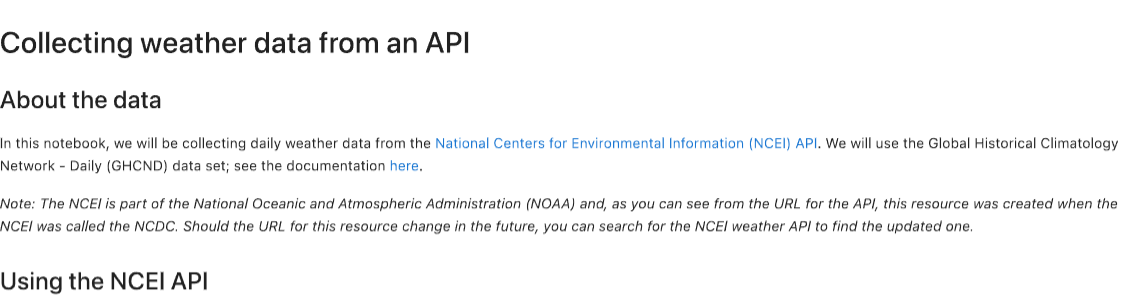

In [30]:
import requests
def make_request(endpoint, payload=None):
  return requests.get(
f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
headers={
'token': 'IJdltvfSEbTvBwFTRJjulcphfvgyAJhH'
},
params=payload
)


#Collect All Data Points for 2018 In NYC (Various Stations)
We can make a loop to query for all the data points one day at a time. Here we create a list of all the results:

In [31]:
import datetime
from IPython import display # for updating the cell dynamically
current = datetime.date(2024, 3, 29)
end = datetime.date(2019, 1, 1)
results = []
while current < end:
    # update the cell with status information
    display.clear_output(wait=True)
    display.display(f'Gathering data for {str(current)}')
    response = make_request(
    'data',
    {
      'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
      'locationid' : 'CITY:US360019', # NYC
      'startdate' : current,
      'enddate' : current,
      'units' : 'metric',
      'limit' : 1000
    }
  )
if response.ok:
    # we extend the list instead of appending to avoid getting a nested list
    results.extend(response.json()['results'])
    # update the current date to avoid an infinite loop
    current += datetime.timedelta(days=1)


Now, we can create a dataframe with all this data. Notice there are multiple stations with values for each datatype on a given day. We don't know what the stations are, but we
can look them up and add them to the data:

In [32]:
import pandas as pd
df = pd.DataFrame(results)
df.head()

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude
0,36.6,2015-07-30,2017-11-19,41.064100,"STAMFORD 2.6 SSW, CT US",0.1469,GHCND:US1CTFR0022,METERS,-73.577000
1,6.4,2016-05-01,2022-04-12,41.037788,"STAMFORD 4.2 S, CT US",0.8790,GHCND:US1CTFR0039,METERS,-73.568176
2,20.1,2008-01-25,2009-11-05,40.921298,"BERGENFIELD 0.3 SW, NJ US",0.2826,GHCND:US1NJBG0001,METERS,-74.001983
3,16.8,2008-02-09,2017-11-23,40.902694,"SADDLE BROOK TWP 0.6 E, NJ US",0.9779,GHCND:US1NJBG0002,METERS,-74.083358
4,21.6,2008-01-29,2024-03-29,40.914670,"TENAFLY 1.3 W, NJ US",0.8979,GHCND:US1NJBG0003,METERS,-73.977500


and write it to the database:

In [33]:
df.to_csv('nyc_weather_2018.csv', index=False)

So when creating this I've noticed that I put the year wrong so instead of March 29 2024 it was March 29 2018 which created a infinite loop that made me think that its just how it is.

In [34]:
import sqlite3
with sqlite3.connect('weather.db') as connection:
  df.to_sql(
    'weather', connection, index=False, if_exists='replace'
)

In [37]:
# Make the request to fetch weather stations data
response = make_request(
    'stations',
    {
        'datasetid': 'GHCND',  # Global Historical Climatology Network - Daily (GHCND) dataset
        'locationid': 'CITY:US360019',  # NYC
        'limit': 1000  # max allowed
    }
)
if response is not None:
    try:
        # Parse the JSON response and create a DataFrame
        stations_data = response.json().get('results', [])
        stations_df = pd.DataFrame(stations_data)[['id', 'name', 'latitude', 'longitude', 'elevation']]

        # Save the DataFrame to a CSV file
        stations_df.to_csv('weather_stations.csv', index=False)
        print("Weather stations data has been saved to 'weather_stations.csv'")
    except Exception as e:
        print("Error:", e)
else:
    print("Failed to fetch weather stations data.")

Weather stations data has been saved to 'weather_stations.csv'


In [42]:
check=pd.read_csv('weather_stations.csv')
(check.head())

,id,name,latitude,longitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,-74.001983,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,-74.083358,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.914670,-73.977500,21.6


In [38]:
with sqlite3.connect('weather.db') as connection:
  stations.to_sql(
'stations', connection, index=False, if_exists='replace'
)

#Conclusion

When doing this activity it furnishes a comprehensive workflow encompassing data retrieval, manipulation, and storage, facilitating the acquisition of valuable insights into NYC's weather patterns throughout the year 2018. By exemplifying effective API interaction, adept data handling with pandas, and resilient data preservation techniques. Although, I must say I did made some errors when doing this activity.